In [1]:
!pip install tensorflow==2.15.0
!pip install tensorflow-quantum==0.7.3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 37.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard
    Found existing installation

In [2]:
# Update package resources to account for version changes.
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py'>

In [3]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np
import seaborn as sns
import collections

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

This notebook is about a binary classifier that distinguishes between the digits 3 and 6, following Farhi et al

# Data Handling

This section covers the data handling that:

1. Loads the raw data from Keras.
2. Filters the dataset to only 3s and 6s.
3. Downscales the images so they fit can fit in a quantum computer.
4. Removes any contradictory examples.
5. Converts the binary images to Cirq circuits.
6. Converts the Cirq circuits to TensorFlow Quantum circuits.

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

11490434/11490434 [==============================] - 1s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


In [18]:
def filter_mnist_data(x,y):
    keep = (y == 3) | (y == 6)
    x, y = x[keep], y[keep]
    y = y == 3
    return x,y
x_train, y_train = filter_mnist_data(x_train, y_train)
x_test, y_test = filter_mnist_data(x_test, y_test)

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 12049
Number of filtered test examples: 1968


False


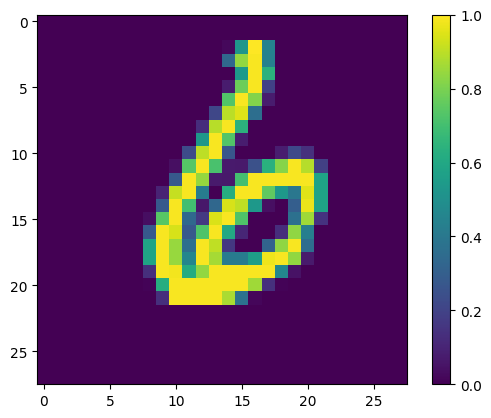

In [19]:
print(y_train[15])

plt.imshow(x_train[15, :, :, 0])
plt.colorbar()

An image size of 28x28 **is much too large** for **current quantum computers**. Resize the image down to 4x4:

In [21]:
x_train_small = tf.image.resize(x_train, (4,4)).numpy()
x_test_small = tf.image.resize(x_test, (4,4)).numpy()

True


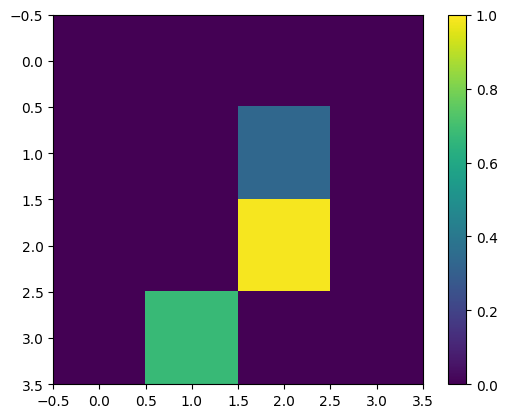

In [22]:
print(y_train[0])

plt.imshow(x_train_small[0,:,:,0], vmin=0, vmax=1)
plt.colorbar()

From section 3.3 Learning to Distinguish Digits of Farhi et al., filter the dataset to remove images that are labeled as belonging to both classes.

In [23]:
def remove_contradicting(xs, ys):
    mapping = collections.defaultdict(set)
    orig_x = {}
    # Determine the set of labels for each unique image:
    for x,y in zip(xs,ys):
       orig_x[tuple(x.flatten())] = x
       mapping[tuple(x.flatten())].add(y)

    new_x = []
    new_y = []
    for flatten_x in mapping:
      x = orig_x[flatten_x]
      labels = mapping[flatten_x]
      if len(labels) == 1:
          new_x.append(x)
          new_y.append(next(iter(labels)))
      else:
          print('Found more than 1 label for a single img: ',labels)
          # Throw out images that match more than one label.
          pass

    num_uniq_3 = sum(1 for value in mapping.values() if len(value) == 1 and True in value)
    num_uniq_6 = sum(1 for value in mapping.values() if len(value) == 1 and False in value)
    num_uniq_both = sum(1 for value in mapping.values() if len(value) == 2)

    print("Number of unique images:", len(mapping.values()))
    print("Number of unique 3s: ", num_uniq_3)
    print("Number of unique 6s: ", num_uniq_6)
    print("Number of unique contradicting labels (both 3 and 6): ", num_uniq_both)
    print()
    print("Initial number of images: ", len(xs))
    print("Remaining non-contradicting unique images: ", len(new_x))

    return np.array(new_x), np.array(new_y)

In [24]:
x_train_nocon, y_train_nocon = remove_contradicting(x_train_small, y_train)

Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a s

# Encode the data as quantum circuits

To process images using a quantum computer, Farhi et al. proposed **representing each pixel with a qubit**, with **the state depending on the value of the pixel**. The first step is to **convert to a binary encoding**.

In [25]:
THRESHOLD = 0.5

x_train_bin = np.array(x_train_nocon > THRESHOLD, dtype=np.float32)
x_test_bin = np.array(x_test_small > THRESHOLD, dtype=np.float32)

In [28]:
np.unique(x_train_bin)

array([0., 1.], dtype=float32)

The binarization process might introduce new image duplicates that didn't exist before. These duplicates could correspond to different labels, which weren't a problem in the original data but become a problem after binarization.

In [29]:
_ = remove_contradicting(x_train_bin, y_train_nocon)

Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a single img:  {False, True}
Found more than 1 label for a s

- By default, **qubits start in the |0⟩ state** (this is the standard initial state in most quantum computers).
- Since qubits start in state |0⟩ by default, applying the X gate to the qubits associated with pixel values of 1 flips those qubits to the |1⟩ state. In this way, **the state** of each qubit reflects **the binary value** of the corresponding pixel in the image.

In [37]:
def convert_pixels_to_cirq_circuit(image):
  values=np.ndarray.flatten(image)
  qubits = cirq.GridQubit.rect(4, 4)
  #each qubit startS in the default state, which is |0⟩
  circuit=cirq.Circuit()
  for i,value in enumerate(values):
    if value:
      circuit.append(cirq.X(qubits[i]))
  return circuit

In [38]:
x_train_circuit = [convert_pixels_to_cirq_circuit(x) for x in x_train_bin]
x_test_circuit = [convert_pixels_to_cirq_circuit(x) for x in x_test_bin]

**Convert these Cirq circuits to tensors for tfq**:

In [39]:
x_train_tfcircuit=tfq.convert_to_tensor(x_train_circuit)
x_test_tfcircuit=tfq.convert_to_tensor(x_test_circuit)

# QNN

There is **little guidance** for a quantum circuit structure that **classifies images**. Since the classification is based on the **expectation of the readout qubit**, Farhi et al. propose using **two qubit gates**, with the readout qubit always acted upon.

The **readout** qubit is a special qubit that **collects or summarizes the information from the data qubits**. At the end of the quantum computation, the state of the readout qubit is measured to yield the output or classification result.

##1- Build the model circuit

Each layer uses **nb_data_qubits instances** of the **same gate**, with **each of the data qubits acting on the readout qubit**.

In [55]:
class CircuitLayerBuilder():
  def __init__(self,data_qubits,readout):
    self.data_qubits=data_qubits
    self.readout=readout
  def add_layer(self,circuit,gate,prefix):
    for i,qubit in enumerate(self.data_qubits):
      symbol=sympy.Symbol(prefix+'-'+str(i))
      circuit.append(gate(qubit,self.readout)**symbol)

##2- Create the quantum model

In [60]:
def create_quantum_model():
  data_qubits=cirq.GridQubit.rect(4,4)
  readout_qubit=cirq.GridQubit(-1,-1)
  circuit=cirq.Circuit()
  circuit.append(cirq.X(readout_qubit))
  circuit.append(cirq.H(readout_qubit))
  circuit_builder=CircuitLayerBuilder(data_qubits,readout_qubit)
  circuit_builder.add_layer(circuit,cirq.XX,"xx1")
  circuit_builder.add_layer(circuit,cirq.ZZ,"zz1")
  #put the readout in superposition again
  circuit.append(cirq.H(readout_qubit))
  #measure the readout qubit in the Z basis
  measured_readout=cirq.Z(readout_qubit)
  return circuit,measured_readout

In [61]:
model_circuit, model_readout = create_quantum_model()

The **superposition state of the readout qubit** allows it to capture **the combined influence of the layers of gates** that have been applied to the data qubits. This is essential for tasks such as classification, where the output reflects the interactions between the data qubits.

The operations performed by the circuit layers (like **cirq.XX and cirq.ZZ** )
 might **collapse the state of the readout qubit** or change its characteristics.

By applying the **Hadamard gate again**, you are reestablishing a state of superposition, allowing the qubit to be influenced by the operations applied during the data processing.

##3- Wrap the model-circuit in a tfq-keras model

In [63]:
model=tf.keras.Sequential([
    tf.keras.layers.Input(shape=(),dtype=tf.dtypes.string),
    tfq.layers.PQC(model_circuit,model_readout)
]
)

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomUniform is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


**The PQC layer returns the expected value of the readout gate, range [-1,1].**

Since the the expected readout is in the range **[-1,1]**, optimizing the **hinge loss** is a somewhat natural fit.

To use the hinge loss here we need to convert the labels, **from [0,1] to [-1,1]**, as expected by the hinge loss.

In [64]:
y_train_hinge = 2.0*y_train_nocon-1.0
y_test_hinge = 2.0*y_test-1.0

In [65]:
def hinge_accuracy(y_true, y_pred):
    y_true = tf.squeeze(y_true) > 0.0
    y_pred = tf.squeeze(y_pred) > 0.0
    result = tf.cast(y_true == y_pred, tf.float32)

    return tf.reduce_mean(result)

In [66]:
model.compile(
    loss=tf.keras.losses.Hinge(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=[hinge_accuracy])

##4- Train

Now train the model—this takes about 45 min. If you don't want to wait that long, use a small subset of the data (set NUM_EXAMPLES=500, below). This doesn't really affect the model's progress during training (it only has 32 parameters, and doesn't need much data to constrain these). Using fewer examples just ends training earlier (5min), but runs long enough to show that it is making progress in the validation logs.

In [68]:
len(x_train_tfcircuit)

10338

In [69]:
NUM_EXAMPLES = 500

In [71]:
x_train_tfcirc_sub = x_train_tfcircuit[:NUM_EXAMPLES]
y_train_hinge_sub = y_train_hinge[:NUM_EXAMPLES]

In [72]:
qnn_history = model.fit(
      x_train_tfcirc_sub, y_train_hinge_sub,
      batch_size=32,
      epochs=3,
      verbose=1,
      validation_data=(x_test_tfcircuit, y_test_hinge))

Epoch 1/3
16/16 [==============================] - 104s 6s/step - loss: 0.9995 - hinge_accuracy: 0.5781 - val_loss: 0.9985 - val_hinge_accuracy: 0.6159
Epoch 2/3
16/16 [==============================] - 87s 6s/step - loss: 0.9983 - hinge_accuracy: 0.6039 - val_loss: 0.9963 - val_hinge_accuracy: 0.6583
Epoch 3/3
16/16 [==============================] - 92s 6s/step - loss: 0.9950 - hinge_accuracy: 0.6195 - val_loss: 0.9904 - val_hinge_accuracy: 0.6799


In [73]:
qnn_results = model.evaluate(x_test_tfcircuit, y_test)

62/62 [==============================] - 36s 566ms/step - loss: 0.9904 - hinge_accuracy: 0.6799


##5- Comparison to an equivalent classical NN (37 params)

In [74]:
def create_fair_classical_model():
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=(4,4,1)))
    model.add(tf.keras.layers.Dense(2, activation='relu'))
    model.add(tf.keras.layers.Dense(1))
    return model


model = create_fair_classical_model()
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 16)                0         
                                                                 
 dense (Dense)               (None, 2)                 34        
                                                                 
 dense_1 (Dense)             (None, 1)                 3         
                                                                 
Total params: 37 (148.00 Byte)
Trainable params: 37 (148.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [75]:
model.fit(x_train_bin,
          y_train_nocon,
          batch_size=128,
          epochs=20,
          verbose=2,
          validation_data=(x_test_bin, y_test))

fair_nn_results = model.evaluate(x_test_bin, y_test)

Epoch 1/20
81/81 - 5s - loss: 0.5960 - accuracy: 0.5249 - val_loss: 0.5658 - val_accuracy: 0.4868 - 5s/epoch - 61ms/step
Epoch 2/20
81/81 - 0s - loss: 0.5479 - accuracy: 0.5249 - val_loss: 0.5208 - val_accuracy: 0.4868 - 479ms/epoch - 6ms/step
Epoch 3/20
81/81 - 1s - loss: 0.5073 - accuracy: 0.5249 - val_loss: 0.4833 - val_accuracy: 0.4868 - 540ms/epoch - 7ms/step
Epoch 4/20
81/81 - 0s - loss: 0.4731 - accuracy: 0.5249 - val_loss: 0.4522 - val_accuracy: 0.4868 - 472ms/epoch - 6ms/step
Epoch 5/20
81/81 - 1s - loss: 0.4445 - accuracy: 0.5249 - val_loss: 0.4254 - val_accuracy: 0.4868 - 525ms/epoch - 6ms/step
Epoch 6/20
81/81 - 0s - loss: 0.4195 - accuracy: 0.5249 - val_loss: 0.4015 - val_accuracy: 0.4868 - 497ms/epoch - 6ms/step
Epoch 7/20
81/81 - 1s - loss: 0.3985 - accuracy: 0.7748 - val_loss: 0.3826 - val_accuracy: 0.8196 - 505ms/epoch - 6ms/step
Epoch 8/20
81/81 - 0s - loss: 0.3818 - accuracy: 0.8401 - val_loss: 0.3674 - val_accuracy: 0.8374 - 447ms/epoch - 6ms/step
Epoch 9/20
81/81 -

The **classical model of similar power (~32 parameters)** trains to a **similar accuracy** in **a fraction of the time (with a higher nb of epochs)**. One way or the other, the classical neural network easily outperforms the quantum neural network. For classical data, it is difficult to beat a classical neural network.